<a href="https://colab.research.google.com/github/alrevus00/Try1/blob/main/Practica_1_Datos_de_entrada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Práctica 1: Datos de entrada

##Datos balanceados y no balanceados

#### Conjunto de datos ¿balanceado?

source: https://elitedatascience.com/imbalanced-classes

Vamos a usar como entrada el conjunto de datos que se encuentra en la siguiente URL "http://archive.ics.uci.edu/ml/machine-learning-databases/balance-scale/balance-scale.data", son unos datos sintéticos y los vamos a usar para entender que ocurre cuando los datos se encuentran balanceados o no.

Las variables 1,2,3 y 4 son numéricas y cada instancia ha sido clasificada de la siguiente manera 
*   si var1\*var2=var3\*var4 entonces se clasifica como B, 
*   si var1\*var2 > var3\*var4 entonces se clasifica como L
*   si var1\*var2 < var3\*var4 entonces se clasifica como R



Cargamos las librerías que vamos a utilizar:

In [75]:
import pandas as pd
import numpy as np

Leemos los datos y mostramos los 5 primeros valores

In [76]:
# Leer dataset
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/balance-scale/balance-scale.data"
df = pd.read_csv(url, sep=",", 
                 names=['balance', 'var1', 'var2', 'var3', 'var4'])
 
# Mostrar las n primeras filas del dataset
df.head(5)

,balance,var1,var2,var3,var4
0,B,1,1,1,1
1,R,1,1,1,2
2,R,1,1,1,3
3,R,1,1,1,4
4,R,1,1,1,5


Vemos cuantas instancias hay de cada clase:

In [77]:
df['balance'].value_counts()

R    288
L    288
B     49
Name: balance, dtype: int64

Vemos que hay dos clases con el mismo número de datos (R y L) y otra que no (B). Para simplificar en este ejemplo vamos a convertir este problema, en un problema de clasificación binaria.

Para ello vamos a re-etiquetar las instancias de la siguiente manera:
- las observaciones que son R y L serán etiquetadas como 0 (clase negativa)
- al resto de observaciones, las que están clasificadas como B, las re-etiquetaremos como 1 (clase positiva).

In [78]:
# Transformación del dataset a un conjunto binario
df['balance'] = [1 if b=='B' else 0 for b in df.balance]

# Mostrar el número de instancias para cada valor de la clase
df['balance'].value_counts()

0    576
1     49
Name: balance, dtype: int64

Como podemos ver, el 92% de la muestra es de la clase 0, esto quiere decir, que si **siempre** tuviéramos que predecir la clase 0, tendríamos un acierto del 92%.

El problema surge que nosotros no vamos a querer clasificar siempre una misma clase.

Veamos como afecta un conjunto de datos balanceado o no a la solución de un problema.

Para ello vamos a usar el algoritmo de Regresión Logística (se explicará con detenimiento más adelante) y la métrica de exactitud (o *accuracy*), ambos de la librería Scikit-Learn.

In [79]:
#importamos las librerías correspondientes al algoritmo y la métrica
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

A la hora de usar el algoritmo de Regresión Logística (que no nos engañe el nombre, es un algoritmo de clasificación), vamos a usarlo con los parámetros que vienen por defecto, ya que nuestra intención ahora es ver la diferencia entre datos balanceados y sin balancear.

Más adelante trabajaremos sobre como separar los datos para entrenar, testear y validar, en este punto vamos a entrenar y testear con todo el conjunto de datos.

In [80]:
# Separamos las características (X) y la variable objetivo (y)
y = df.balance
X = df.drop('balance', axis=1)
 
# Entrenamos el modelo
model_lr = LogisticRegression().fit(X, y)
model_knn=KNeighborsClassifier().fit(X,y)
 
# Predecimos sobre el conjunto de entreanmiento
pred_y_lr = model_lr.predict(X)
pred_y_knn=model_knn.predict(X)

Muchos algoritmos están diseñados para maximizar la exactitud (*accuracy*) por defecto:

In [81]:
#¿Cómo es la accuracy?
print( accuracy_score(pred_y_lr, y) )
print( accuracy_score(pred_y_knn, y) )

0.9216
0.9136


Confirmamos así que el acierto de nuestro modelo es del 92% pero, ¿ocurre esto por qué sólo está prediciendo una clase?

In [82]:
# Mostramos los valores predichos (una vez cada valor)
print( np.unique( pred_y_lr ) )

[0]


De esta manera, comprobamos que este modelo sólo está prediciendo la clase 0, lo que significa que está ignorando la clase minoritaria a favor de la clase mayoritaria. 

EJERCICIO: comprueba si el modelo knn predice sólo una clase o por el contrario predice de las dos.

In [83]:
print( np.unique( pred_y_knn ) )

[0 1]


In [84]:
# el modelo pred_y_knn predice para ambas clases

Veamos dos técnicas para equilibrar esto:

##Remuestreo Aleatorio

####1. Aumentar la muestra de la clase minoritaria 

El proceso de aumentar la muestra consiste en duplicar aleatoriamente las observaciones de la clase minoritaria para reforzar su señal.

Existen varias heurísticas para hacerlo, pero la forma más común es simplemente volver a muestrear con reemplazo.

Veamos como podemos hacerlo, pero primero cargamos el modulo *resample* de Scikit-Learn que vamos a usar:

In [85]:
from sklearn.utils import resample

El primer paso es crear un nuevo *DataFrame* con el nuevo conjunto de datos para la clase minoritaria. Para ello:
1. Separamos las instancias en grupos, un grupo por cada una de las clases que hay.
2. Re-muestreamos la clase minoritaria usando remplazamineto, y obteniendo el mismo número de muestras que la clase mayoritaria.
3. Finalmente, combinaremos en un nuevo *DataFrame* el nuevo grupo de datos de la clase que era minoritaria y el grupo original de la clase mayoritaria.
Para nuestro ejemplo, el código sería el siguiente:

In [86]:
# Separar las clases mayoritaria y minoritaria
df_majority = df[df.balance==0]
df_minority = df[df.balance==1]
 
# Aumentar la muestra de la clase minoritaria
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # muestra con remplazamiento
                                 n_samples=576,    # número de muestras de la clase mayoritaria
                                 random_state=123) # semilla para que los resultados sean reproducibles
 
# Combinar el nuevo grupo con el grupo original mayoritario
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Mostrar el número de instancias en cada clase
df_upsampled.balance.value_counts()

1    576
0    576
Name: balance, dtype: int64

Como podemos ver, el nuevo *DataFrame* tiene más instancias que el original y ahora, el ratio entre las dos clases es de 1:1.

Ahora, usando este conjunto de datos balanceado, vamos a entrenar un modelo de regresión logística.

In [87]:
# Separar las características (X) y la variable objetivo o clase (y)
y = df_upsampled.balance
X = df_upsampled.drop('balance', axis=1)
 
# Entrenar el modelo
model_lr = LogisticRegression().fit(X, y)
 
# Predecir en el conjunto de entrenamiento
pred_y_lr = model_lr.predict(X)
 
# Comprobamos cuáles y cuántas clases predice nuestro modelo
print( np.unique( pred_y_lr ) )


[0 1]


In [88]:
# ¿qué accuracy tenemos ahora?
print( accuracy_score(y, pred_y_lr) )

0.5147569444444444


Observamos que ahora nuestro modelo no predice sólo una clase, sin embargo es cierto que la *accuracy* ha disminuido.Pero tenemos que tener en cuenta que este valor es más significativo com métrica de lo que está sucediendo, de cuál es el rendimiento del modelo.

####2. Disminuir la muestra de la clase mayoritaria

Disminuir el número de instancias de la clase mayoritaria implica la eliminación aleatoria de observaciones para evitar que su señal domine el algoritmo de aprendizaje.

La heurística más común para hacerlo es el remuestreo sin reemplazo.

El proceso es similar al de muestreo visto anteriormente:

1. Separamos las instancias de cada clase en diferentes *DataFrame*.
2. Volvemos a muestrear la clase mayoritaria, esta vez sin remplazo y estableciendo el número de muestras para que coincida con el de la clase minoritaria.
3. Finalmente, combinaremos el nuevo *DataFrame* de la clase mayoritaria con el *DataFrame* original de la clase minoritaria.

In [89]:
# Separar las clases en diferentes DataFrame
df_majority = df[df.balance==0]
df_minority = df[df.balance==1]
 
# Disminuir la clase mayoritaria
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # muestra sin remplazamiento
                                 n_samples=49,     # número de muestras de la clase minoritaria
                                 random_state=123) # semilla para que los datos sean reproducibles
 
# Combinar el nuevo grupo con el grupo original minoritario
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Mostrar el número de instancias en cada clase
df_downsampled.balance.value_counts()

1    49
0    49
Name: balance, dtype: int64

Esta vez, el nuevo *DataFrame* ha disminuido el número de instancias con respecto a su original, y el ratio entre las dos clases, vuelve a ser de 1:1.

Veamos ahora que ocurre si entrenamos con el algoritmo de regresión logística.

In [90]:
# Separar las características (X) y la variable objetivo o clase (y)
y = df_downsampled.balance
X = df_downsampled.drop('balance', axis=1)
 
# Entrenar el modelo
clf_2 = LogisticRegression().fit(X, y)
 
# Predecir en el conjunto de entrenamiento
pred_y_2 = clf_2.predict(X)
 
# Comprobamos cuáles y cuántas clases predice nuestro modelo
print( np.unique( pred_y_2 ) )

[0 1]


In [91]:
# ¿qué accuracy tenemos ahora?
print( accuracy_score(y, pred_y_2) )

0.5612244897959183


Con esta técnica hemos vuelto a evitar que el modelo prediga sólo una clase y además parece que la *accuracy* es más alta.The model isn't predicting just one class, and the accuracy seems higher.

Todavía nos quedaría validar el modelo sobre unos datos que no hayan sido usados en el entrenamiento.

Veamos ahora otra técnica para balancear nuestras muestras.

####3. Combinar ambas técnicas: aumentar y disminuir muestras

EJERCICIO: La clase mayoritaria tiene en nuestro ejemplo 576 instancias y la clase minoritaria 49, vamos a balancear el conjunto de datos aumentando la clase minoritaria y disminuyendo la clase mayoritaria a 312 muestras. Elegimos este número de instancias porque de esta manera hacemos que el número de muestras que se generan y que se eliminan en cada clase es el mismo.

Comprueba que accuracy saldría si usamos el mismo método de entrenamiento que en los casos individuales.

In [102]:
# Separar las clases en diferentes DataFrame
df_majority = df[df.balance==0]
df_minority = df[df.balance==1]


 
# Aumentar la muestra de la clase minoritaria
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # muestra con remplazamiento
                                 n_samples=312,    # número de muestras de la clase mayoritaria
                                 random_state=123) # semilla para que los resultados sean reproducibles

# Disminuir la clase mayoritaria
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # muestra sin remplazamiento
                                 n_samples=312,     # número de muestras de la clase minoritaria
                                 random_state=123) # semilla para que los datos sean reproducibles
 
# Combinar el nuevo grupo con el grupo original minoritario
df_downsampled = pd.concat([df_majority_downsampled, df_minority_upsampled])
 
# Mostrar el número de instancias en cada clase
df_downsampled.balance.value_counts()


1    312
0    312
Name: balance, dtype: int64

In [104]:
# Separar las características (X) y la variable objetivo o clase (y)
y = df_downsampled.balance
X = df_downsampled.drop('balance', axis=1)
 
# Entrenar el modelo
clf_2 = LogisticRegression().fit(X, y)
 
# Predecir en el conjunto de entrenamiento
pred_y_2 = clf_2.predict(X)
 
# Comprobamos cuáles y cuántas clases predice nuestro modelo
print( np.unique( pred_y_2 ) )

[0 1]


In [105]:
print( accuracy_score(y, pred_y_2) )

0.530448717948718


In [ ]:
# Con 49 muestras en ambas clases la precisión era mayor

EJERCICO: Visto que ocurre aplicando cada técnica por separado y combinándolas ¿qué número de muestra crees que será una mejor elección para nuestro ejemplo?
- aquella que requiera que el número de muestras de oversampling sea mayor (400 instancias)
- o aquella que requiera que el número de muestras de oversampling sea menor (100 instancias)

Probar si nuestra hipótesis es cierta para este ejemplo. ¿qué ocurre?

In [106]:
# Separar las clases en diferentes DataFrame
df_majority = df[df.balance==0]
df_minority = df[df.balance==1]


 
# Aumentar la muestra de la clase minoritaria
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # muestra con remplazamiento
                                 n_samples=400,    # número de muestras de la clase mayoritaria
                                 random_state=123) # semilla para que los resultados sean reproducibles

# Disminuir la clase mayoritaria
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # muestra sin remplazamiento
                                 n_samples=400,     # número de muestras de la clase minoritaria
                                 random_state=123) # semilla para que los datos sean reproducibles
 
# Combinar el nuevo grupo con el grupo original minoritario
df_downsampled = pd.concat([df_majority_downsampled, df_minority_upsampled])
 
# Mostrar el número de instancias en cada clase
df_downsampled.balance.value_counts()


1    400
0    400
Name: balance, dtype: int64

In [107]:
# Separar las características (X) y la variable objetivo o clase (y)
y = df_downsampled.balance
X = df_downsampled.drop('balance', axis=1)
 
# Entrenar el modelo
clf_2 = LogisticRegression().fit(X, y)
 
# Predecir en el conjunto de entrenamiento
pred_y_2 = clf_2.predict(X)
 
# Comprobamos cuáles y cuántas clases predice nuestro modelo
print( np.unique( pred_y_2 ) )

[0 1]


In [108]:
print( accuracy_score(y, pred_y_2) )

0.49625


In [ ]:
#Los dos con 400 tiene una precisión mala

In [109]:
# Separar las clases en diferentes DataFrame
df_majority = df[df.balance==0]
df_minority = df[df.balance==1]


 
# Aumentar la muestra de la clase minoritaria
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # muestra con remplazamiento
                                 n_samples=100,    # número de muestras de la clase mayoritaria
                                 random_state=123) # semilla para que los resultados sean reproducibles

# Disminuir la clase mayoritaria
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # muestra sin remplazamiento
                                 n_samples=100,     # número de muestras de la clase minoritaria
                                 random_state=123) # semilla para que los datos sean reproducibles
 
# Combinar el nuevo grupo con el grupo original minoritario
df_downsampled = pd.concat([df_majority_downsampled, df_minority_upsampled])
 
# Mostrar el número de instancias en cada clase
df_downsampled.balance.value_counts()

1    100
0    100
Name: balance, dtype: int64

In [110]:
# Separar las características (X) y la variable objetivo o clase (y)
y = df_downsampled.balance
X = df_downsampled.drop('balance', axis=1)
 
# Entrenar el modelo
clf_2 = LogisticRegression().fit(X, y)
 
# Predecir en el conjunto de entrenamiento
pred_y_2 = clf_2.predict(X)
 
# Comprobamos cuáles y cuántas clases predice nuestro modelo
print( np.unique( pred_y_2 ) )

[0 1]


In [111]:
print( accuracy_score(y, pred_y_2) )

0.55


In [ ]:
#Tal y como esperabamos con 100 muestras tenemos mayor precisión. 

EJERCICIO OPCIONAL: existe otra librería que incluye estos métodos de balanceo de datos *imblearn* y los métodos se definen como *RandomOverSampling* y *RandomUnderSampling*. Lee como se usa y prueba a usarlos como hemos hecho con los métodos de la librería Scikit-Learn (oversampling, undersampling, y combinado).


In [122]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler 

### SMOTE: Synthetic Minority Oversampling TEchnique

Como hemos visto una manera de solucionar el problema de que una clase tenga menos muestras que otra, es duplicar las instancias de la clase minoritaria en el conjunto de entrenamiento. Así obtenemos un conjunto balanceado pero esta solución no proporciona información adicional al modelo.

Si en lugar de duplicar las instancias de la clase minoritaria *sintetizamos* (creamos de manera artificial) nuevas instancias que pertenezcan a esta muestra.

Quizás una de las técnicas más usadas es la que se denomina **Synthetic Minority Oversampling TEchnique** (SMOTE). Esta técnica fue descrita por Nitesh Chawla et al. en 2002 en el artículo "[SMOTE: Synthetic Minority Oversampñling Technique](https://arxiv.org/abs/1106.1813)".

SMOTE funciona seleccionando ejemplos cercanos en el espacio de características, dibujando una línea entre los ejemplos en el espacio de características y dibujando una nueva muestra en un punto a lo largo de esa línea.

Específicamente, primero se elige un ejemplo aleatorio de la clase minoritaria. Entonces se encuentran k de los vecinos más cercanos para ese ejemplo (típicamente k = 5). Se elige un vecino seleccionado al azar y se crea un ejemplo sintético en un punto seleccionado al azar entre los dos ejemplos en el espacio de características.
Este procedimiento se puede utilizar para crear tantos ejemplos sintéticos para la clase minoritaria como sean necesarios. Como se describe en el documento, sugiere usar primero un submuestreo aleatorio para recortar el número de ejemplos en la clase mayoritaria, luego usar SMOTE para sobremuestrear la clase minoritaria para equilibrar la distribución de clases.

A continuación vemos un ejemplo de uso , y para ello vamos a necesitar la librería *imbalanced-learn*

In [112]:
# Comprobamos que está instalada y cuál es su versión
import imblearn
print(imblearn.__version__)
from imblearn.over_sampling import SMOTE

0.8.1


Importamos las librerías que se van a usar

In [113]:
# Resto de librerías que vamos a usar
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where

Definimos un conjunto de datos aleatorio con dos clases. Para ello usamos la instrucción *make_classification* del módulo datasets de la librería Scikit-Learn.

Lo que hace este método es crear conjuntos de datos multiclase, asignando a cada clase una o más instancias distribuidas normalmente. Este método está especializado en introducir ruido por medio de las muestras, es decir, genera caracterísitcas correlacionas, redundantes y no informativas.


In [114]:
# Creamos el conjunto de datos aleatorio
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# Mostramos como está distribuida la variable objetivo 
counter = Counter(y)
print(counter)

Counter({0: 9900, 1: 100})


Dibujamos como sería nuestro dataset

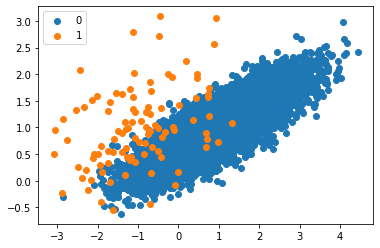

In [115]:
# Dibujamos en un gráfico el dataset creado
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

Aplicamos la técnica SMOTE:

In [116]:
# Transformamos el conjunto de datos
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# Obtenemos la nueva distribución de clases en la variable y
counter = Counter(y)
print(counter)

Counter({0: 9900, 1: 9900})


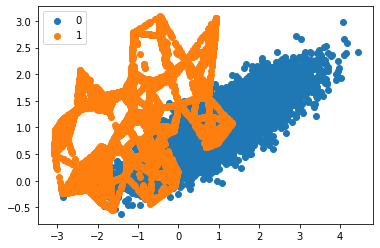

In [117]:
# # Dibujamos en un gráfico el dataset transformado
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

El artículo original sobre SMOTE sugirió combinar SMOTE con un submuestreo aleatorio de la clase mayoritaria.

La biblioteca de aprendizaje desequilibrado admite submuestreo aleatorio a través de la clase RandomUnderSampler.

Podemos actualizar el ejemplo para sobremuestrear primero la clase minoritaria para tener un 10 por ciento del número de ejemplos de la clase mayoritaria (por ejemplo, alrededor de 1000), luego usar un submuestreo aleatorio para reducir el número de ejemplos en la clase mayoritaria para tener un 50 por ciento más que el clase minoritaria (por ejemplo, alrededor de 2000).

Para implementar esto, podemos especificar las proporciones deseadas como argumentos para las clases SMOTE y RandomUnderSampler;

Volvemos a definir el conjunto de datos original.

In [118]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# summarize class distribution
counter = Counter(y)
print(counter)

Counter({0: 9900, 1: 100})


A continuación, se transforma el conjunto de datos, primero sobremuestreando la clase minoritaria y luego submuestreando la clase mayoritaria. 

La distribución de clases final después de esta secuencia de transformaciones coincide con una proporción de 1: 2 o aproximadamente 2000 ejemplos en la clase mayoritaria y aproximadamente 1000 ejemplos en la clase minoritaria.

In [123]:
# define pipeline
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)


Counter({0: 1980, 1: 990})


Mostramos el resultado mediante un *ScatterPlot* o gráfico de puntos.

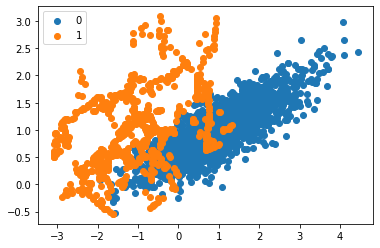

In [124]:
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

###ADASYN: Adaptative Synthetic Sampling Approach For Imbalanced Learning

Otro enfoque implica la generación de muestras sintéticas inversamente proporcional a la densidad de los ejemplos de la clase minoritaria.

Es decir, generar más ejemplos sintéticos en regiones del espacio de características donde la densidad de ejemplos minoritarios es menor que la densidad de la clase mayoritaria.

Esta modificación de SMOTE se conoce como Método de muestreo sintético adaptativo, o ADASYN, y se propuso a Haibo He, et al. en su artículo de 2008 llamado así por el método titulado “[ADASYN: Adaptive Synthetic Sampling Approach For Imbalanced Learning.](https://sci2s.ugr.es/keel/pdf/algorithm/congreso/2008-He-ieee.pdf)”.

La idea clave del algoritmo ADASYN es utilizar una distribución de densidad como criterio para decidir automáticamente el número de muestras sintéticas que deben generarse para cada ejemplo de datos minoritarios.

Podemos aplicar este procedimiento utilizando la clase ADASYN en la librería *imbalanced-learn*

El siguiente ejemplo demuestra este enfoque alternativo al sobremuestreo en el conjunto de datos de clasificación binaria desequilibrado. 

La idea clave del algoritmo ADASYN es utilizar una distribución de densidad como criterio para decidir automáticamente el número de muestras sintéticas que deben generarse para cada ejemplo de datos minoritarios.

Cargamos las librerías que vamos a necesitar:

In [125]:
# Oversample and plot imbalanced dataset with ADASYN
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import ADASYN
from matplotlib import pyplot
from numpy import where

Volvemos a crear un conjunto de datos de dos clases con dos características para usarlo como ejemplo.

In [126]:
# Definir un dataset  aleatorio dónde de 10000 muestras 100 sean de una clase y el resto de la otra
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# Resumen de la distribución
counter = Counter(y)
print(counter)

Counter({0: 9900, 1: 100})


Usamos el método ADASYN que está en la librería imbalanced-learn.

In [127]:
# Transformar el conjunto de datos
oversample = ADASYN()
X, y = oversample.fit_resample(X, y)
# Resumen de la distribución
counter = Counter(y)
print(counter)

Counter({0: 9900, 1: 9899})


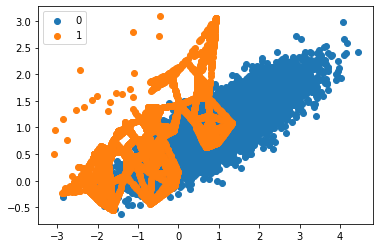

In [128]:
# Dibujar como es la distribución de la muestra
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

EJERCICIO: Tanto el método SMOTE y ADASYN se basan para sintetizar nuevas muestras en el estudio de los k vecinos de cada una de las muestras. Por defecto se ha comentado que ambos métodos usan k=5. Prueba a ver que ocurre con k=3 y con k=7, ¿cambia mucho el conjunto final según el número de vecinos que usemos? 

EJERCICIO:

Aplica las técnicas de Aumentar la muestra (Oversampling), Disminuir la muestra (Undersampling), SMOTE y ADASYN sobre el conjunto de datos que se encuentra en 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv'. 

Este conjunto de datos es original National Institute of Diabetes and Digestive and Kidney Diseases y se usa para predecir si un paciente tiene diabetes o no basada en las medidas de diagnóstico que se recogen en los datos.

El nombre de las columnas del conjunto de datos son ['NO_PREG','PLASMA_GLUCOSE','DIASTOLIC_BP','SKIN_THICKNESS','SERUM_INSULIN','BMI','DIA_PEDI_FUNC','AGE','TARGET'] siendo la última, la característica objetivo.

EJERCICIO OPCIONAL: Una vez tengas los conjuntos balanceados para los cuatro tipos de métodos, calcula la *accuracy* que sale al aplicar el método de Regresión Logística sobre cada conjunto, teniendo en cuenta que el valor de la *accuracy* ha de estar entre 0 y 1 siendo 1 el mejor resultado: ¿Hay alguno que sea claramente mejor?

###One-Class Classification

EJERCICIO OPCIONAL: En clase de teoría se ha explicado que una estrategia para balancear una clase y de esta manera poder eliminar ruido del dataset (posibles datos anómalos) es usar el método *One-Class Classification* (Clasificación de una clase).

Crea una conjunto de datos aleatorio con 10000 muestras, dónde de la clase minoritaria sólo haya 10, siendo la distribución de la muestra 1:1000.

La librería *scikit-learn* tiene implementado varios algoritmos de clasificación para una clase, en particular: 


*   One-class SVM
*   Isolation Forest

Busca como usar uno de estos dos métodos y ponlo en práctica en el conjunto de datos generado. 

